In [1]:
import gym
import talib
import random
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
from collections import deque
import tensorflow as tf
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import models, layers, optimizers
%matplotlib inline

In [2]:
class DenseNetwork(models.Model):
    
    def __init__(self, input_sz, output_sz, hidden_sz):
        super(DenseNetwork, self).__init__()
        self.input_layer = layers.InputLayer(input_shape=(input_sz,))
        self.hidden_layer = [layers.Dense(i, activation='relu') for i in hidden_sz]
        self.output_layer = layers.Dense(output_sz, activation = 'linear')
        
    def call(self, x):
        x = self.input_layer(x)
        for l in self.hidden_layer:
            x = l(x)
        return self.output_layer(x)

In [3]:
class DDQNAgent():

    def __init__(self, 
                 state_size=None, 
                 action_size=None,
                 hidden_size=[64,64],
                 maxlen=10000,
                 lr=0.001,
                 batch_size=128,
                 gamma=0.99,
                 epsilon=1.0,
                 epsilon_decay_factor=0.9999,
                 epsilon_min = 0.01,
                 Architecture=DenseNetwork):
        
        self.state_size = state_size  
        self.action_size = action_size  
        
        self.discount_factor = gamma
        self.learning_rate = lr
        self.epsilon = epsilon
        self.epsilon_decay_factor = epsilon_decay_factor 
        self.epsilon_min = epsilon_min
        
        self.hidden_size = hidden_size
        
        self.model = Architecture(self.state_size, self.action_size, self.hidden_size)
        self.target_model = Architecture(self.state_size, self.action_size, self.hidden_size) 
        
        self.copy_weights(self.model, self.target_model)
        
        self.optimizer = tf.keras.optimizers.Adam(lr=self.learning_rate)

        self.maxlen = maxlen
        self.memory = deque(maxlen=self.maxlen) 
        self.batch_size = batch_size
        
        self.losses = []
    
    def __str__(self):
        return "Parameter(Discount:%s, Epsilon_decay:%s, Maxlen:%s, batch:%s)" %(self.discount_factor, 
                                                                                 self.epsilon_decay_factor, 
                                                                                 self.maxlen, 
                                                                                 self.batch_size)
    
    def copy_weights(self, Copy_from, Copy_to):
        var2 = Copy_from.trainable_variables
        var1 = Copy_to.trainable_variables
        for v1, v2 in zip(var1, var2):
            v1.assign(v2.numpy())

    def get_action(self, state):
        optimal_action = np.argmax(self.model.call(state)[0])
        random_action = random.randint(0, self.action_size - 1)
        action = np.random.choice([optimal_action, random_action], p=[1 - self.epsilon, self.epsilon])
        return action
    
    def save_sample(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay_factor
    
    def vanilla_loss(self, target, q):
        return tf.keras.losses.mse(target, q)
    
    def train_model(self):
        if len(self.memory) >= self.batch_size:
            state, action, reward, next_state, done = zip(*random.sample(self.memory, self.batch_size)) 

            state = tf.cast(np.vstack(state), dtype=tf.float32)
            action = tf.squeeze(tf.cast(np.vstack(action), dtype=tf.int32), axis=1) 
            reward = tf.squeeze(tf.cast(np.vstack(reward), dtype=tf.float32))
            next_state = tf.cast(np.vstack(next_state), dtype=tf.float32)
            done = tf.squeeze(tf.cast(np.vstack(done), dtype=tf.float32))
            
            q_target = self.model.call(state)
            target_next = self.model.call(next_state) #For predict argmax next_state
            target_val = self.target_model.call(next_state) #Predict value     

            a = np.argmax(target_next, axis=1)
            target = reward + self.discount_factor * \
                    np.array([target_val[i][a[i]] for i in range(self.batch_size)]) * \
                    (tf.ones(self.batch_size) - done)
            
            q_target = q_target.numpy()
            target = target.numpy()
            
            q_target[np.arange(self.batch_size), list(action)] = target
            q_target = tf.convert_to_tensor(q_target, dtype=tf.float32)
            
            with tf.GradientTape() as tape:
                q_s_a = self.model.call(state)
                
                loss = self.vanilla_loss(q_target, q_s_a)
                self.losses.append(loss.numpy().sum())
                
                gradients = tape.gradient(loss, self.model.trainable_weights)
                
            self.optimizer.apply_gradients(zip(gradients, self.model.trainable_weights))

            return loss    
 

In [4]:
if __name__ == "__main__":
    
    env = gym.make('LunarLander-v2')
    agent = DDQNAgent(env.observation_space.shape[0], env.action_space.n, [100,100,100], epsilon_decay_factor=0.9995, maxlen=5000)
    number_of_episodes = 500
    total_reward = np.zeros(number_of_episodes)
    freq = 5

    for i in tqdm_notebook(range(number_of_episodes)):
        count = 0
        state = env.reset()
        state = np.reshape(state, [1,env.observation_space.shape[0]])
           
        while True:
            count += 1
            env.render()
            
            #take action
            action = agent.get_action(state)
            next_state, reward, done, _ = env.step(action)
            next_state = np.reshape(next_state, [1,env.observation_space.shape[0]])
            
            agent.save_sample(state, action, reward, next_state, done)
                
            if count % freq == 0:
                agent.train_model()
            
            state = next_state
            total_reward[i] += reward

            if done:
                env.render()
                
                if total_reward[i]>=200:
                    agent.model.save_weights('Luna.h5')
                
                agent.copy_weights(agent.model, agent.target_model)
                
                if i % 50 == 0:
                    print(f'Episode: {i+1}')
                    print(f"Avg_Reward: {total_reward[:i+1].mean():.4f}")
                    print(f'Epsilon: {agent.epsilon:.4f}')
                    print('='*18)
                
                break
       
    agent.model.save_weights('Luna_last.h5')
    plt.plot(total_reward)
    plt.plot(talib.EMA(total_reward, timeperiod=50))
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('Performance',fontsize=18)
    plt.show()
    env.close()

<ipython-input-4-0507932903ed>:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(number_of_episodes)):


  0%|          | 0/500 [00:00<?, ?it/s]

Episode: 1
Avg_Reward: -355.8361
Epsilon: 0.9512


KeyboardInterrupt: 

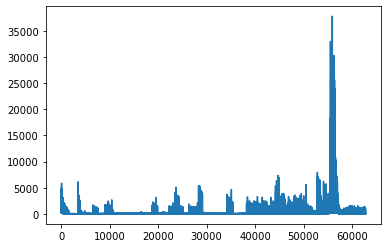

In [13]:
plt.plot(agent.losses)

# Play

In [10]:
env_test = gym.make('LunarLander-v2')
model = DenseNetwork(env_test.observation_space.shape[0], env_test.action_space.n, [100,100,100])
model.build((None, env_test.observation_space.shape[0]))
model.load_weights('Luna_last.h5')

In [11]:
number_of_episode = 5

total_reward = np.zeros(number_of_episode)
    
for i in tqdm_notebook(range(number_of_episode)):
    state = env_test.reset()
    state = np.reshape(state, [1,env_test.observation_space.shape[0]])
           
    while True:
        env_test.render()
        
        action = np.argmax(model.call(state)[0])
        next_state, reward, done, _ = env_test.step(action)
        state = np.reshape(next_state, [1,env_test.observation_space.shape[0]])
        total_reward[i] += reward
            
        if done:
            env_test.render()
            break
env_test.close()
plt.plot(total_reward)

<ipython-input-11-1ef5f0daa667>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(number_of_episode)):


  0%|          | 0/10 [00:00<?, ?it/s]

KeyboardInterrupt: 